# Projections fix of global data:

In [1]:
# run script that installs missing libraries
! chmod 755 scripts.sh
! ./scripts.sh

  Using cached google_cloud_storage-2.2.1-py2.py3-none-any.whl (107 kB)
  Using cached google_cloud_storage-2.2.0-py2.py3-none-any.whl (107 kB)


### imports

In [2]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs

import pyproj
from pyproj import Transformer

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

In [4]:
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Global data:
Global data is in LON/LAT and need to go to Polar Stereographic (variant B) coordinates.


char crs(char1) ;
              crs:long_name = "Polar Stereographic (variant B)" ;
              crs:grid_mapping_name = "polar_stereographic" ;
              crs:standard_name = "polar_stereographic" ;
              crs:authority = "EPSG:3031" ;
              crs:standard_parallel = -71.f ;
              crs:longitude_of_prime_meridian = 0.f ;
              crs:straight_vertical_longitude_from_pole = 0.f ;
              crs:semi_major_axis = 6378137.f ;
              crs:inverse_flattening = 298.2572f ;
              crs:latitude_of_projection_origin = -90.f ;
              crs:false_easting = 0.f ;
              crs:false_northing = 0.f

In [5]:
#dg = xr.open_dataset('../data/year_ACCESS1-3.nc2', decode_times=False)
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3.zarr'
dg = xr.open_zarr('gs://'+globalName, decode_times=False)
# rename some variables
dg = dg.rename({'TIME2':'TIME', 'PLEV12_15':'PLEV'})

# get starting date and units of dataset
units, reference_date = dg.TIME.attrs['units'].split('since')
print('Units: {} and reference date: {} of global dataset'.format(units, reference_date))

# set reference date, add first value in time array
START = datetime(1950,1,15,0,0,0)+timedelta(days=dg.TIME[0].values*30)

print('First date in time array: {}'.format(START))

# Correct the time by having a yearly range from the starting date till 2100
#dg['TIME'] = pd.date_range(start=START, periods=dg.sizes['TIME2'], freq='12M')
# Need to assign new coordinates so that the coordinates of values also change
dg = dg.assign_coords(TIME=pd.date_range(start=START, periods=dg.sizes['TIME'], freq='12M'))
dg.load()

Units: month(360days)  and reference date:  1950-01-15 00:00:00 of global dataset
First date in time array: 1950-06-29 00:00:00


<xarray.Dataset>
Dimensions:         (LAT: 144, LON: 192, PLEV: 4, bnds: 2, TIME: 151)
Coordinates:
  * LAT             (LAT) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * LON             (LON) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * TIME            (TIME) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (TIME, PLEV, LAT, LON) float32 232.7 232.7 ... 267.7 267.7
    TAS             (TIME, LAT, LON) float32 225.6 225.6 225.5 ... 271.3 271.3
    TIME2_bnds      (TIME, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (TIME, PLEV, LAT, LON) float32 0.6384 0.6994 ... -2.163
    VA              (TIME, PLEV, LAT, LON) float32 -1.574 -1.541 ... -0.3436
    ZG              (TIME, PLEV, LAT, LON) float32 4.961e+03 ... 1.368e+03
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

### Global antarctica plot:

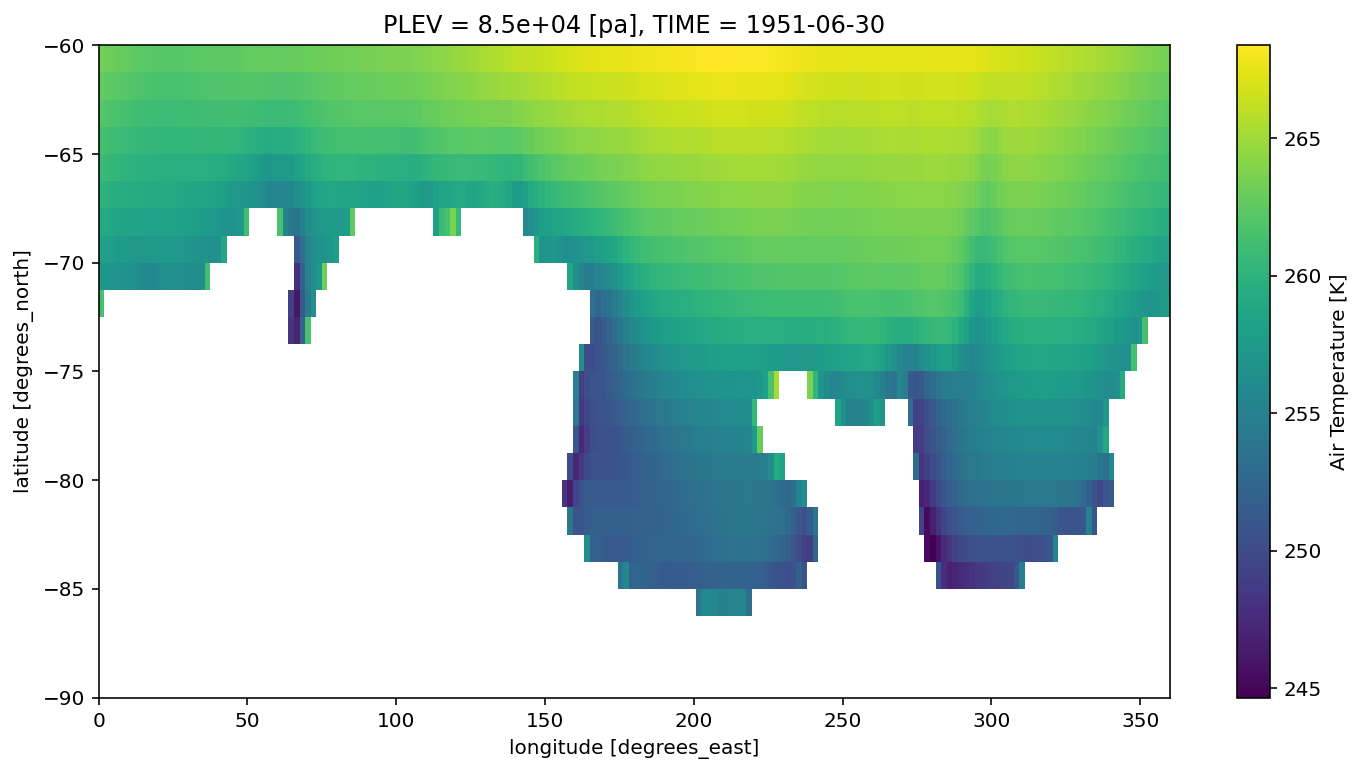

In [6]:
# plot the first timestep
# define antarctica as 90° S to 60° S in latitude and full longitude
nlimit=-60
lat = dg.LAT.sel(LAT=slice(-90,nlimit))
lon = dg.LON

antarctica = dg.sel(LAT=slice(-90,nlimit))
antarctica.TA.isel(TIME=1, PLEV = 3).plot(x="LON")

## Regional antarctica plot:

In [7]:
# Regional data:
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
SF = dsr.SF
SF = SF.rename({'X':'x', 'Y':'y','TIME':'time'})
SF.load()

<xarray.DataArray 'SF' (time: 121, y: 148, x: 176)>
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 8.2238734e-04, 1.7702754e-03, ...,
         2.4849612e-01, 1.3752687e-01, 0.0000000e+00],
        [0.0000000e+00, 9.5873623e-04, 3.1730002e-03, ...,
         4.7328660e-01, 9.7627938e-02, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 1.3972830e-02, ...,
         8.4334040e-01, 1.7932276e-01, 0.0000000e+00],
        [0.0000000e+00, 1.7528790e-01, 0.0000000e+00, ...,
         1.8794355e-01, 2.6358142e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9237557e-02, 9.3792170e-02, ...,
         3.2130305e-02, 1.8263299e-03, 0.0000000e+00],
        [0.0000000e+00, 4.5042731e-02, 1.9937153e-01, ...,
         9.0562895e-02, 2.7440168e-02, 0.0000000e+00],
...
        [0.0000000e+00, 1.9066806e-03, 2.9245628e-02, ...,
         3.1920848e-05, 1.3089844e-04, 0.0000000e+00],
        [0.0000000e+00, 4.8599821e-03, 7.4016866e-03, ...,
         8.8025299e-05, 6.6868735e-05, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 4.3029156e-02, 1.8392896e-02, ...,
         7.1365736e-02, 4.1550115e-02, 0.0000000e+00],
        [0.0000000e+00, 6.7392007e-02, 1.4771838e-02, ...,
         6.4517774e-02, 7.1482062e-02, 0.0000000e+00],
        ...,
        [0.0000000e+00, 2.8324102e-03, 3.6359030e-05, ...,
         3.0855291e-02, 2.5267785e-03, 0.0000000e+00],
        [0.0000000e+00, 1.6912237e-03, 2.4980045e-04, ...,
         5.9821073e-04, 2.6016415e-03, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * x        (x) float32 -3.01e+03 -2.975e+03 -2.94e+03 ... 3.08e+03 3.115e+03
  * y        (y) float32 -2.555e+03 -2.52e+03 -2.485e+03 ... 2.555e+03 2.59e+03
Attributes:
    long_name:  Snowfall
    units:      kg m-2 yr-1

Text(0.4, 1.05, 'Regional SF in polar stereographic projection')

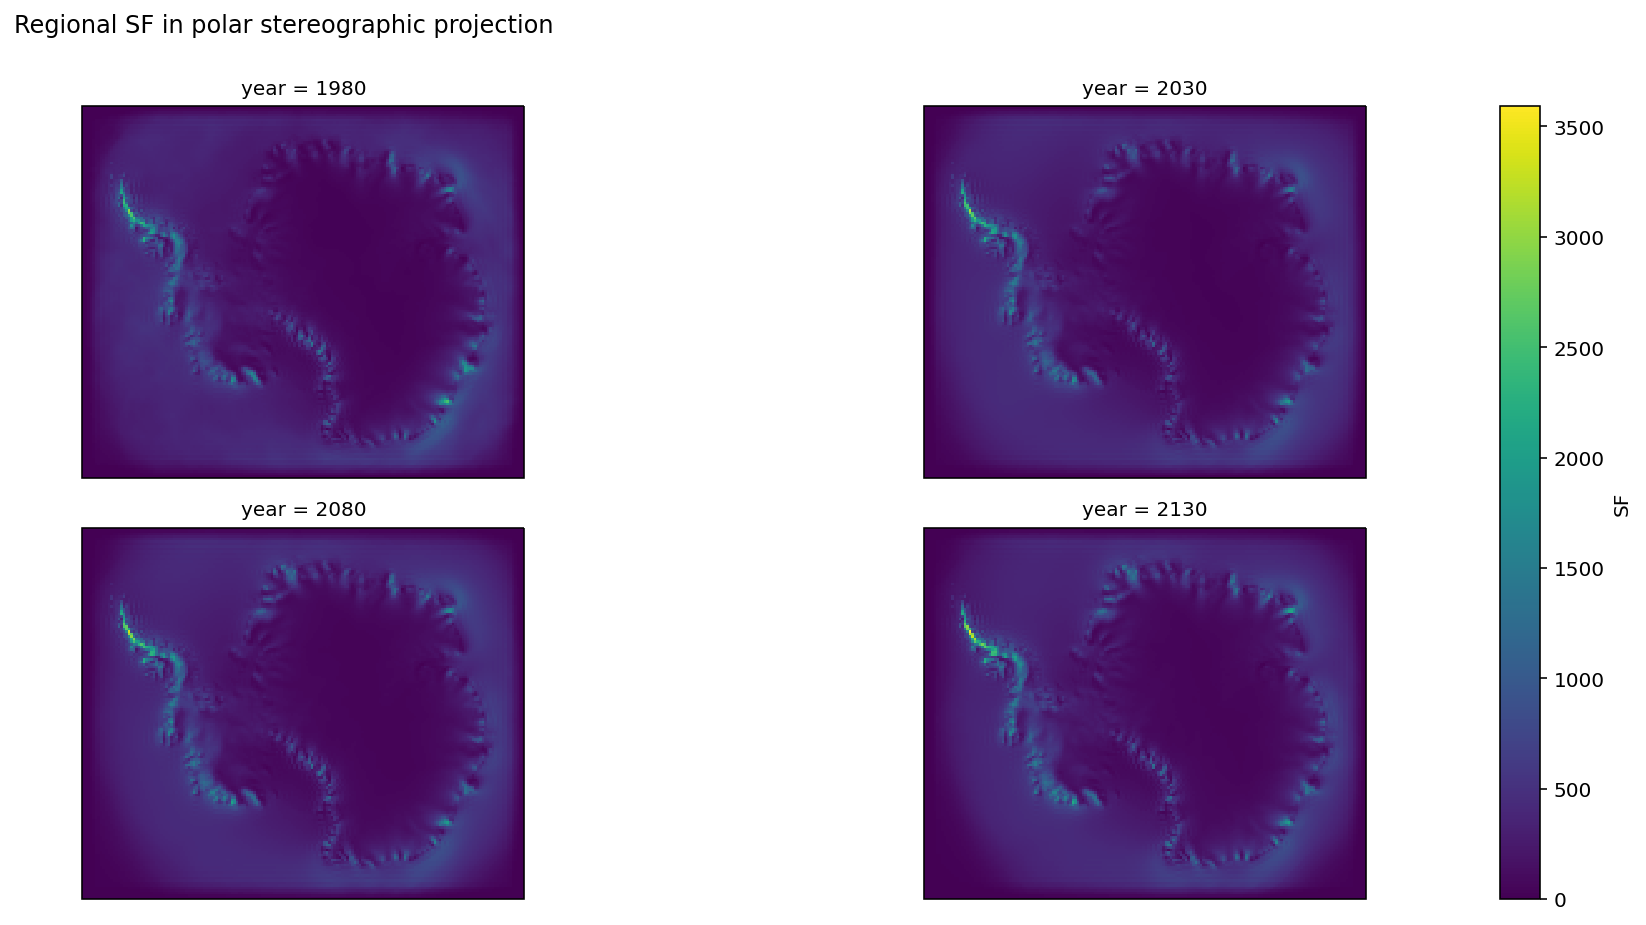

In [8]:
# plot the first timestep of regional data:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0)
decades = SF.resample(time="50Y").mean().groupby("time.year").mean()
p  = decades.plot(x="x", col="year", col_wrap=2,aspect=3, 
                  subplot_kws={"projection": map_proj}, transform=ccrs.SouthPolarStereo())
for ax in p.axes.flat:
    ax.coastlines(color = 'white')
plt.suptitle('Regional SF in polar stereographic projection', y=1.05, x = 0.4)

## Play with cartopy reprojections:
- Antarctic Polar stereographic coordinates is EPSG:3031
- LAT/LON is EPSG:4326

In [9]:
# Reproject Near surface temperature:
TAS = antarctica.TAS
TAS = TAS.rename({'LAT':'latitude', 'LON':'longitude','TIME':'time'})
TAS = TAS.sortby(["time", "latitude", "longitude"])
TASlatlon = TAS.rio.write_crs("epsg:4326")
TASlatlon.load()

<xarray.DataArray 'TAS' (time: 151, latitude: 24, longitude: 192)>
array([[[225.60596, 225.573  , 225.54031, ..., 225.69899, 225.66858,
         225.63809],
        [227.09897, 227.019  , 226.94092, ..., 227.34073, 227.26048,
         227.17978],
        [227.76768, 227.60304, 227.45294, ..., 228.33559, 228.13602,
         227.94624],
        ...,
        [264.1662 , 264.4258 , 264.70844, ..., 263.7723 , 263.85028,
         263.96942],
        [265.72302, 265.9029 , 266.11984, ..., 265.44168, 265.51508,
         265.5984 ],
        [267.2454 , 267.32437, 267.47037, ..., 267.07492, 267.14966,
         267.2087 ]],

       [[227.02704, 226.98798, 226.94934, ..., 227.1459 , 227.10675,
         227.06671],
        [228.46278, 228.36365, 228.26584, ..., 228.76862, 228.66727,
         228.56456],
        [229.15747, 228.95845, 228.7711 , ..., 229.8187 , 229.58954,
         229.36833],
...
        [270.32544, 270.2852 , 270.25854, ..., 270.35992, 270.38428,
         270.36594],
        [271.04178, 271.02112, 271.00473, ..., 271.02454, 271.06522,
         271.0605 ],
        [271.68256, 271.68512, 271.71973, ..., 271.71234, 271.71796,
         271.70078]],

       [[232.07898, 232.0415 , 232.00546, ..., 232.19019, 232.15103,
         232.11496],
        [233.42622, 233.33865, 233.25261, ..., 233.70256, 233.61012,
         233.51727],
        [233.97531, 233.79048, 233.61887, ..., 234.59718, 234.38087,
         234.17284],
        ...,
        [270.06744, 270.15576, 270.25024, ..., 269.78125, 269.88898,
         269.9807 ],
        [270.80856, 270.86334, 270.91754, ..., 270.54233, 270.64438,
         270.73566],
        [271.55914, 271.5875 , 271.62534, ..., 271.36194, 271.44724,
         271.516  ]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float64 -89.38 -88.12 -86.88 ... -61.88 -60.62
  * longitude    (longitude) float64 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * time         (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
    spatial_ref  int64 0
Attributes:
    history:        2012-02-05T23:49:51Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    long_name_mod:  regrid: 1.9 deg on X@AAV, 1.2 deg on Y@AAV, 1 mon_360 on ...
    units:          K

#### Plot in original projections:
EPSG:4326 longitude and latitude directly (plate carrée projection)

Text(0.4, 0.92, 'Global TAS in original projection')

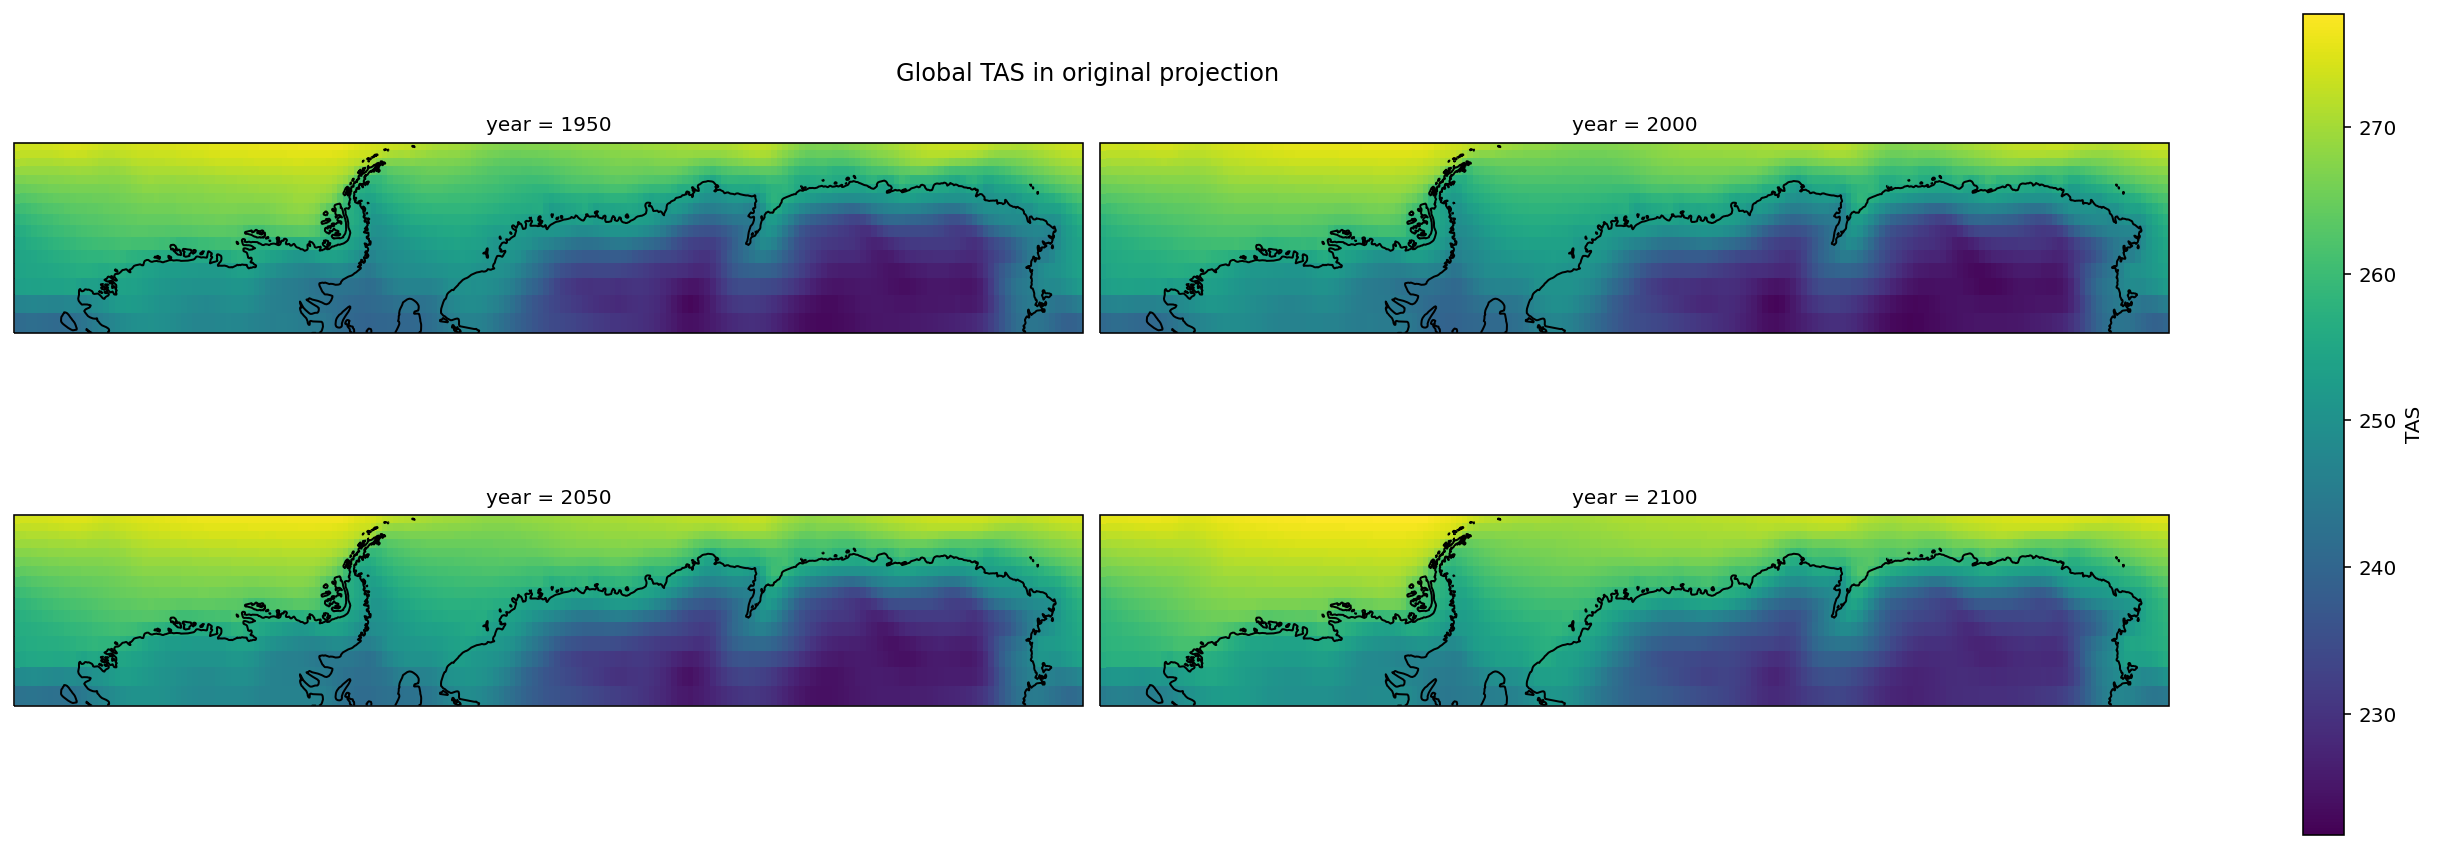

In [10]:
decades = TAS.resample(time="50Y").mean().groupby("time.year").mean()
map_proj = ccrs.Mercator(central_longitude=0)
p = decades.plot(x="longitude", col="year", col_wrap=2, aspect = 3, subplot_kws={"projection": map_proj},
                      transform=ccrs.PlateCarree()) # Plate carrée (EPSG:4326) projection
for ax in p.axes.flat:
    ax.coastlines()
plt.suptitle('Global TAS in original projection', y=0.92, x = 0.4)

#### Plot in polar stereographic projections:
Better projection is the polar stereographic projection (EPSG:3031 for the South Pole) which shows the pole in the middle. Distortions get larger the farther you get away from the pole, but below 60° they are not that bad.

Text(0.4, 1.05, 'Global TAS in polar stereographic projection')

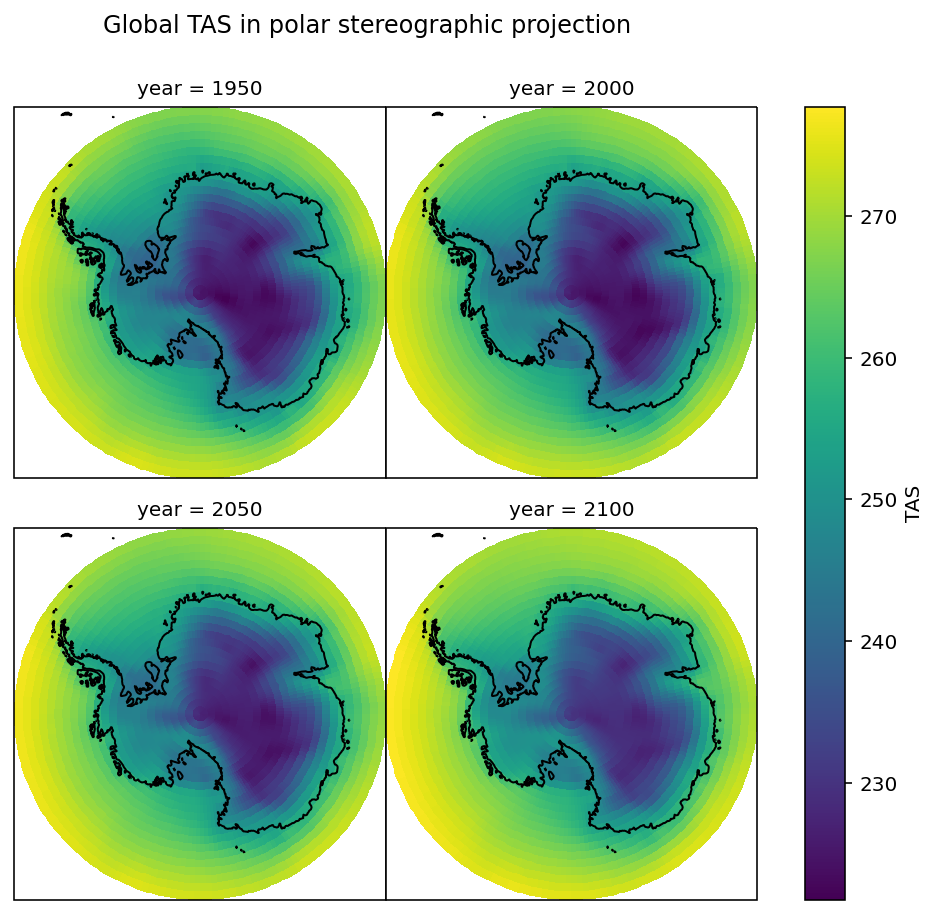

In [11]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
decades = TAS.resample(time="50Y").mean().groupby("time.year").mean()
p  = decades.plot(x="longitude", col="year", col_wrap=2, subplot_kws={"projection": map_proj},
                      transform=ccrs.PlateCarree()) # the data's projection
for ax in p.axes.flat:
    ax.coastlines()
plt.suptitle('Global TAS in polar stereographic projection', y=1.05, x = 0.4)

## Reproject GCM xarray with rasterio:

In [12]:
# Reproject Near surface temperature:
TAS = antarctica.TAS
TAS = TAS.rename({'LAT':'latitude', 'LON':'longitude','TIME':'time'})
TAS = TAS.sortby(["time", "latitude", "longitude"])
TAS_latlon = TAS.rio.write_crs("epsg:4326")
TAS_latlon.load()

<xarray.DataArray 'TAS' (time: 151, latitude: 24, longitude: 192)>
array([[[225.60596, 225.573  , 225.54031, ..., 225.69899, 225.66858,
         225.63809],
        [227.09897, 227.019  , 226.94092, ..., 227.34073, 227.26048,
         227.17978],
        [227.76768, 227.60304, 227.45294, ..., 228.33559, 228.13602,
         227.94624],
        ...,
        [264.1662 , 264.4258 , 264.70844, ..., 263.7723 , 263.85028,
         263.96942],
        [265.72302, 265.9029 , 266.11984, ..., 265.44168, 265.51508,
         265.5984 ],
        [267.2454 , 267.32437, 267.47037, ..., 267.07492, 267.14966,
         267.2087 ]],

       [[227.02704, 226.98798, 226.94934, ..., 227.1459 , 227.10675,
         227.06671],
        [228.46278, 228.36365, 228.26584, ..., 228.76862, 228.66727,
         228.56456],
        [229.15747, 228.95845, 228.7711 , ..., 229.8187 , 229.58954,
         229.36833],
...
        [270.32544, 270.2852 , 270.25854, ..., 270.35992, 270.38428,
         270.36594],
        [271.04178, 271.02112, 271.00473, ..., 271.02454, 271.06522,
         271.0605 ],
        [271.68256, 271.68512, 271.71973, ..., 271.71234, 271.71796,
         271.70078]],

       [[232.07898, 232.0415 , 232.00546, ..., 232.19019, 232.15103,
         232.11496],
        [233.42622, 233.33865, 233.25261, ..., 233.70256, 233.61012,
         233.51727],
        [233.97531, 233.79048, 233.61887, ..., 234.59718, 234.38087,
         234.17284],
        ...,
        [270.06744, 270.15576, 270.25024, ..., 269.78125, 269.88898,
         269.9807 ],
        [270.80856, 270.86334, 270.91754, ..., 270.54233, 270.64438,
         270.73566],
        [271.55914, 271.5875 , 271.62534, ..., 271.36194, 271.44724,
         271.516  ]]], dtype=float32)
Coordinates:
  * latitude     (latitude) float64 -89.38 -88.12 -86.88 ... -61.88 -60.62
  * longitude    (longitude) float64 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * time         (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
    spatial_ref  int64 0
Attributes:
    history:        2012-02-05T23:49:51Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    long_name_mod:  regrid: 1.9 deg on X@AAV, 1.2 deg on Y@AAV, 1 mon_360 on ...
    units:          K

### Rasters:

In [13]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )
# GCM
print("Original GCM:\n----------------\n")
print_raster(TAS)
print("GCM with crs lat/lon epsg:4326:\n----------------\n")
print_raster(TAS_latlon)

# RCM
print("RCM SF x/y:\n----------------\n")
print_raster(SF)
SF_xy = SF.rio.write_crs("epsg:3031")
print("RCM SF with crs x/y epsg:3031:\n----------------\n")
print_raster(SF_xy)

Original GCM:
----------------

shape: (24, 192)
resolution: (1.875, 1.25)
bounds: (0.0, -60.0, 360.0, -90.0)
sum: 172970704.0
CRS: None

GCM with crs lat/lon epsg:4326:
----------------

shape: (24, 192)
resolution: (1.875, 1.25)
bounds: (0.0, -60.0, 360.0, -90.0)
sum: 172970704.0
CRS: EPSG:4326

RCM SF x/y:
----------------

shape: (148, 176)
resolution: (35.00000279017857, 35.0)
bounds: (-3027.5002455357144, 2607.5, 3132.5002455357144, -2572.5)
sum: 874292928.0
CRS: None

RCM SF with crs x/y epsg:3031:
----------------

shape: (148, 176)
resolution: (35.00000279017857, 35.0)
bounds: (-3027.5002455357144, 2607.5, 3132.5002455357144, -2572.5)
sum: 874292928.0
CRS: EPSG:3031



In [14]:
# Convert RCM from km to m:
SF_xy['x'] = SF_xy.x*1000
SF_xy['y'] = SF_xy.y*1000

SF_xy.x.attrs['units'] = 'm'
SF_xy.y.attrs['units'] = 'm'

# Save geotif file
SF_xy.rio.to_raster("SF_xy.tif")
SF_xy.load()

<xarray.DataArray 'SF' (time: 121, y: 148, x: 176)>
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 8.2238734e-04, 1.7702754e-03, ...,
         2.4849612e-01, 1.3752687e-01, 0.0000000e+00],
        [0.0000000e+00, 9.5873623e-04, 3.1730002e-03, ...,
         4.7328660e-01, 9.7627938e-02, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 1.3972830e-02, ...,
         8.4334040e-01, 1.7932276e-01, 0.0000000e+00],
        [0.0000000e+00, 1.7528790e-01, 0.0000000e+00, ...,
         1.8794355e-01, 2.6358142e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9237557e-02, 9.3792170e-02, ...,
         3.2130305e-02, 1.8263299e-03, 0.0000000e+00],
        [0.0000000e+00, 4.5042731e-02, 1.9937153e-01, ...,
         9.0562895e-02, 2.7440168e-02, 0.0000000e+00],
...
        [0.0000000e+00, 1.9066806e-03, 2.9245628e-02, ...,
         3.1920848e-05, 1.3089844e-04, 0.0000000e+00],
        [0.0000000e+00, 4.8599821e-03, 7.4016866e-03, ...,
         8.8025299e-05, 6.6868735e-05, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 4.3029156e-02, 1.8392896e-02, ...,
         7.1365736e-02, 4.1550115e-02, 0.0000000e+00],
        [0.0000000e+00, 6.7392007e-02, 1.4771838e-02, ...,
         6.4517774e-02, 7.1482062e-02, 0.0000000e+00],
        ...,
        [0.0000000e+00, 2.8324102e-03, 3.6359030e-05, ...,
         3.0855291e-02, 2.5267785e-03, 0.0000000e+00],
        [0.0000000e+00, 1.6912237e-03, 2.4980045e-04, ...,
         5.9821073e-04, 2.6016415e-03, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Attributes:
    long_name:  Snowfall
    units:      kg m-2 yr-1

### Rasterio reproject with match:
`rio.reproject_match` will reproject to match the resolution, projection, and region of another raster. Try to reproject on RCM but doesn't work.

In [15]:
TAS_xy = TAS_latlon.rio.reproject_match(SF_xy)
print("GCM crs EPSG:3031 x/y:\n----------------\n")
print_raster(TAS_xy)

print("RCM crs EPSG:3031 x/y:\n----------------\n")
print_raster(SF_xy)

TAS_xy.load()

GCM crs EPSG:3031 x/y:
----------------

shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
sum: 932468864.0
CRS: EPSG:3031

RCM crs EPSG:3031 x/y:
----------------

shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
sum: 874292928.0
CRS: EPSG:3031



<xarray.DataArray 'TAS' (time: 151, y: 148, x: 176)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
  * time         (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
    spatial_ref  int64 0
Attributes:
    history:        2012-02-05T23:49:51Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    long_name_mod:  regrid: 1.9 deg on X@AAV, 1.2 deg on Y@AAV, 1 mon_360 on ...
    units:          K

#### Plot new reprojected GCM:

Text(0.4, 1.05, 'GCM TAS in polar stereographic projection')

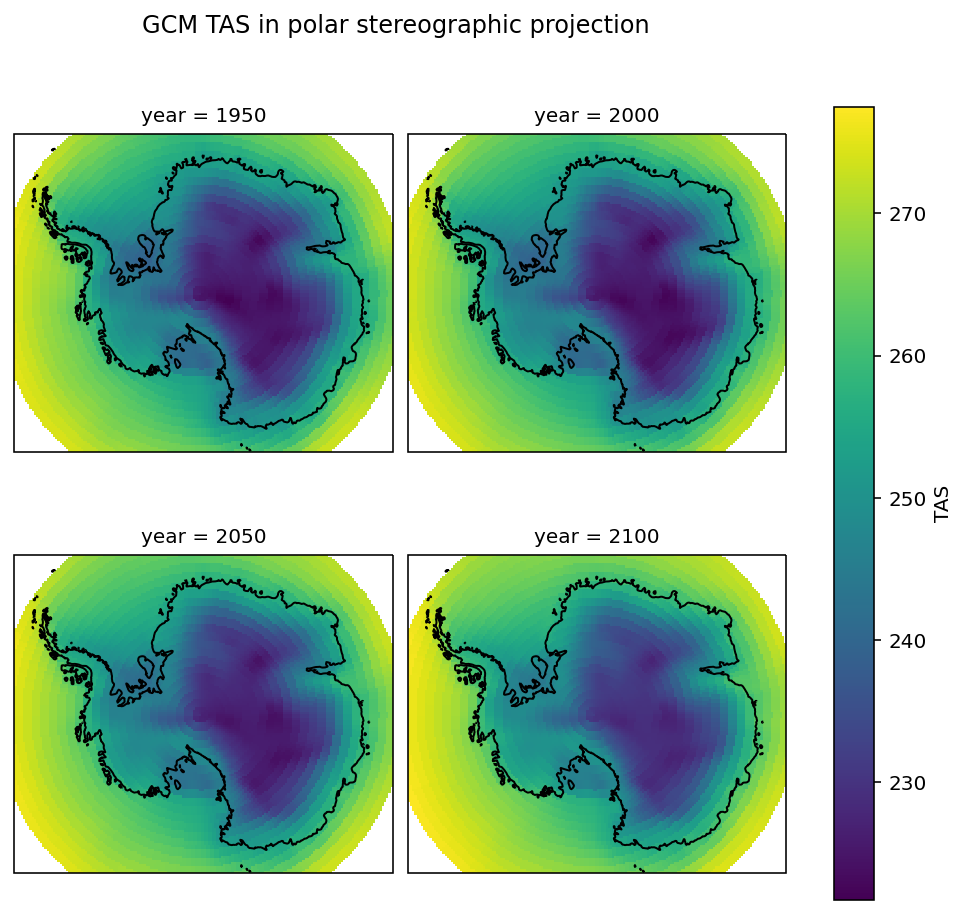

In [16]:
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None) # plot projection
decades = TAS_xy.resample(time="50Y").mean().groupby("time.year").mean()
p  = decades.plot(x="x", col="year", col_wrap=2, subplot_kws={"projection": map_proj},
                      transform=ccrs.SouthPolarStereo()) # data projection
for ax in p.axes.flat:
    ax.coastlines()
plt.suptitle('GCM TAS in polar stereographic projection', y=1.05, x = 0.4)

#### Compare to reprojection made by cartopy:

Text(0.4, 1.05, 'Global TAS in polar stereographic projection')

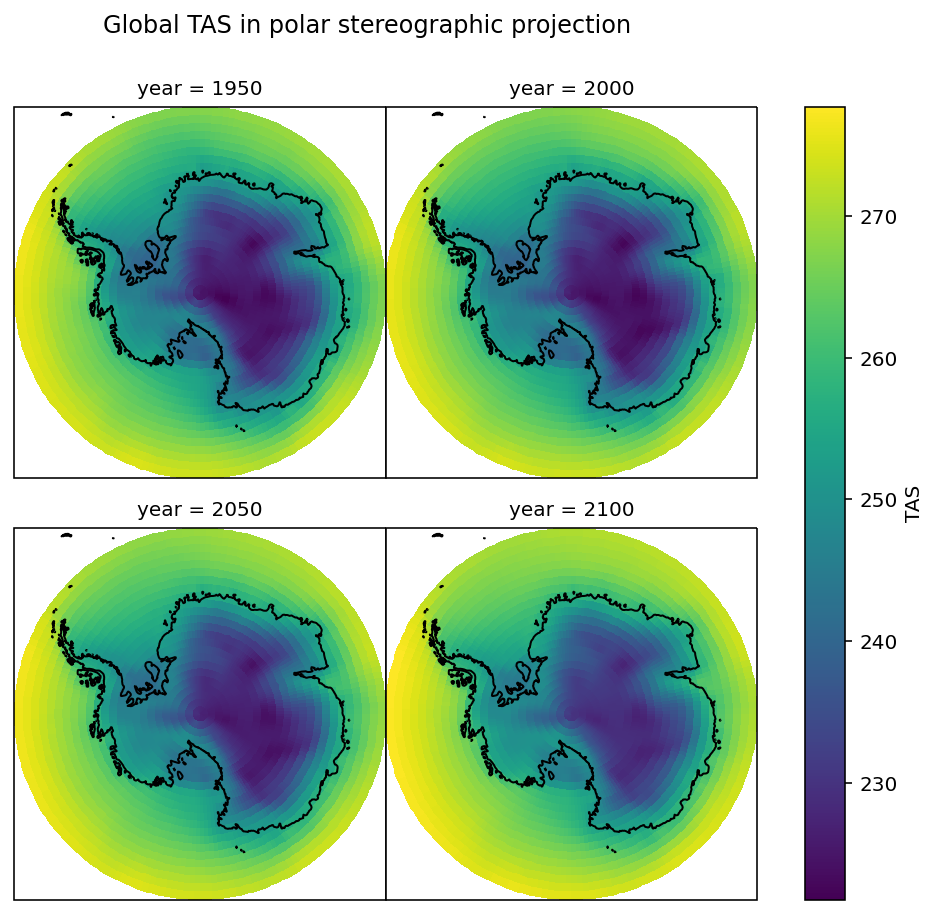

In [17]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
decades = TAS.resample(time="50Y").mean().groupby("time.year").mean()
p  = decades.plot(x="longitude", col="year", col_wrap=2, subplot_kws={"projection": map_proj},
                      transform=ccrs.PlateCarree()) # the data's projection
for ax in p.axes.flat:
    ax.coastlines()
plt.suptitle('Global TAS in polar stereographic projection', y=1.05, x = 0.4)

Text(0.5, 0.98, 'First timestep of reprojected GCM (left) and RCM (right)')

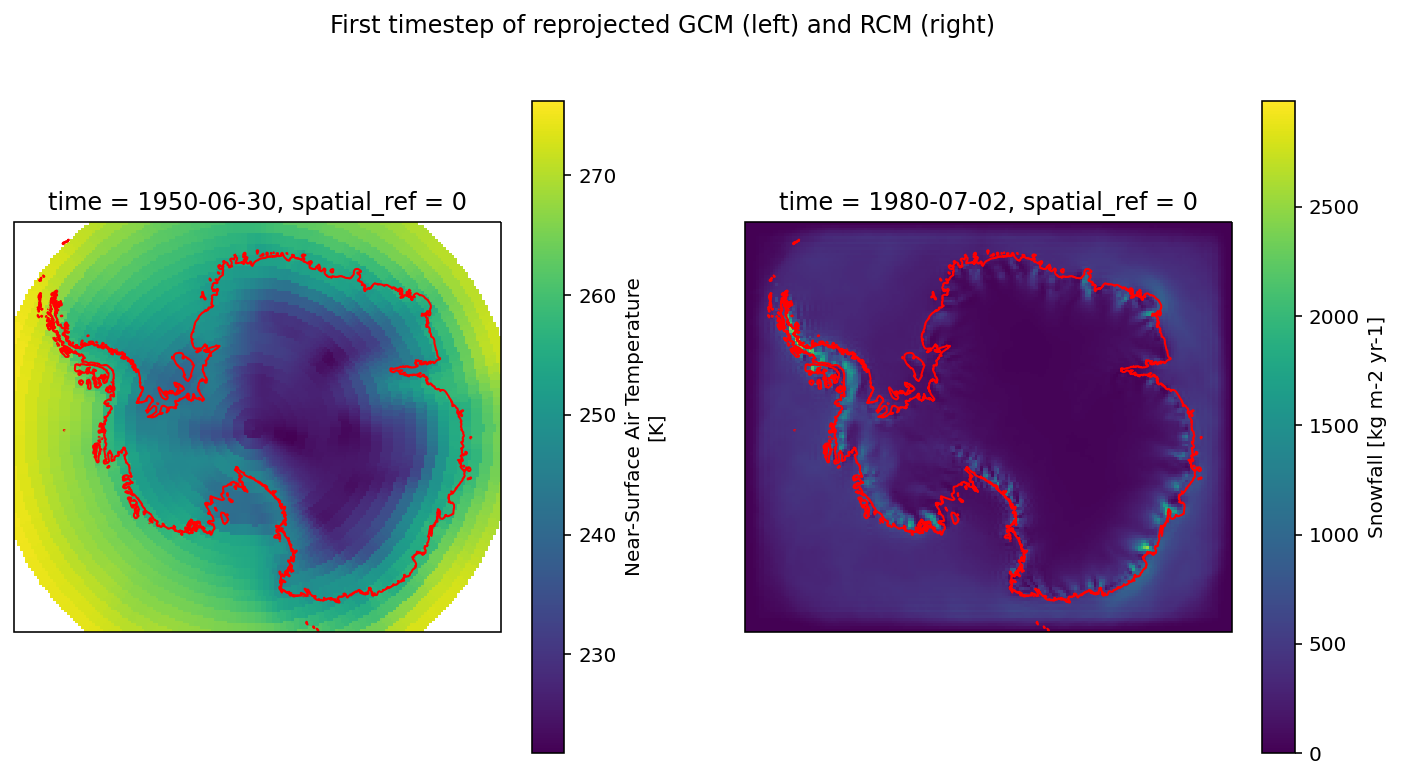

In [18]:
# plot the first timestep of GCM data:
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
ax = plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())
TAS_xy.isel(time = 0).plot(ax=ax, 
                x='x', y='y', 
                transform=ccrs.SouthPolarStereo(),
                add_colorbar=True
               )
ax.coastlines('10m', color='r')
plt.suptitle('First timestep of reprojected GCM')

ax = plt.subplot(1,2,2, projection=ccrs.SouthPolarStereo())
SF_xy.isel(time = 0).plot(ax=ax, 
                x='x', y='y', 
                transform=ccrs.SouthPolarStereo(),
                add_colorbar=True
               )
ax.coastlines('10m', color='r')
plt.suptitle('First timestep of reprojected GCM (left) and RCM (right)')

Text(0.5, 0.98, 'First timestep of reprojected GCM')

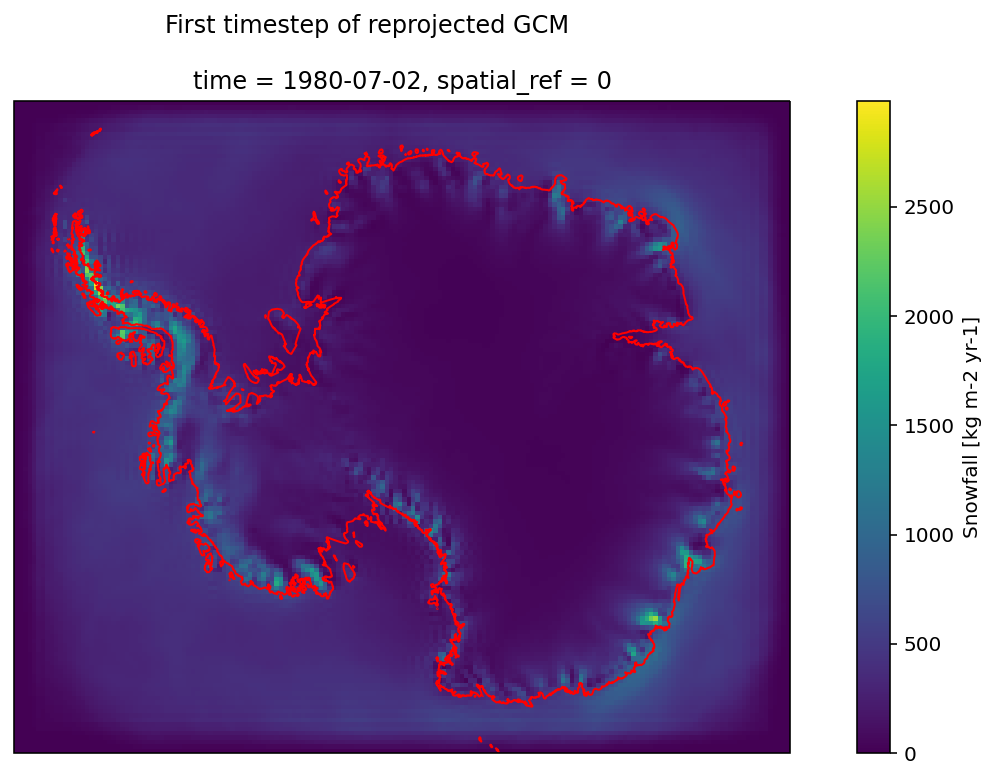

In [19]:
# plot the first timestep of regional data:
#SF.isel(time=1).plot(x="x")

# plot the first timestep of GCM data:
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
ax = plt.subplot(projection=ccrs.SouthPolarStereo())
SF_xy.isel(time = 0).plot(ax=ax, 
                x='x', y='y', 
                transform=ccrs.SouthPolarStereo(),
                add_colorbar=True
               )
ax.coastlines('10m', color='r')
plt.suptitle('First timestep of reprojected GCM')

### Rasterio transform with geotif:
Can transform coordinates but miss interpolation on new transformed grid. So works for plots but not enough for ML. 

In [20]:
# Reproject Near surface temperature:
TAS = antarctica.TAS
TAS = TAS.rename({'LAT':'lat', 'LON':'lon','TIME':'time'})
TAS = TAS.sortby(["time", "lat", "lon"])

# Define the source and target projections
source_crs = "epsg:4326" # lat/lon
target_crs = "epsg:3031" # polar stereographic

TAS_latlon = TAS.rio.write_crs(source_crs)
TAS_latlon.attrs['crs']  = f'+init={source_crs}'

In [21]:
TAS_latlon.rio.to_raster("TASlatlon.tif")
da = xr.open_rasterio('TASlatlon.tif')
da = da.rename({'y':'lat','x':'lon'})
print(f'Initial EPSG: {da.crs}')

# Create a grid of lat/lon values for the lat/lon grid of GCM over antarctic
lonmesh, latmesh = np.meshgrid(da.lon, da.lat)


# Create a pyproj.Transformer to transform each point 
# in lonmesh and lastmesh into a location in the polar coordinates
transformer = Transformer.from_crs(source_crs, 
                                   target_crs,
                                   always_xy=True,
                                  ) 

xv, yv = transformer.transform(lonmesh, latmesh)
TAS_xy = TAS_latlon.copy()
TAS_xy.coords['x'] = (('lat', 'lon'), xv) # (dims, data) 
TAS_xy.coords['y'] = (('lat', 'lon'), yv) # (dims, data)
TAS_xy.attrs['crs']  = f'+init={target_crs}'
print(f'New EPSG: {TAS_latlon.crs}')
TAS_xy.load()

Initial EPSG: +init=epsg:4326
New EPSG: +init=epsg:4326


/tmp/ipykernel_761/882697387.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  da = xr.open_rasterio('TASlatlon.tif')


<xarray.DataArray 'TAS' (time: 151, lat: 24, lon: 192)>
array([[[225.60596, 225.573  , 225.54031, ..., 225.69899, 225.66858,
         225.63809],
        [227.09897, 227.019  , 226.94092, ..., 227.34073, 227.26048,
         227.17978],
        [227.76768, 227.60304, 227.45294, ..., 228.33559, 228.13602,
         227.94624],
        ...,
        [264.1662 , 264.4258 , 264.70844, ..., 263.7723 , 263.85028,
         263.96942],
        [265.72302, 265.9029 , 266.11984, ..., 265.44168, 265.51508,
         265.5984 ],
        [267.2454 , 267.32437, 267.47037, ..., 267.07492, 267.14966,
         267.2087 ]],

       [[227.02704, 226.98798, 226.94934, ..., 227.1459 , 227.10675,
         227.06671],
        [228.46278, 228.36365, 228.26584, ..., 228.76862, 228.66727,
         228.56456],
        [229.15747, 228.95845, 228.7711 , ..., 229.8187 , 229.58954,
         229.36833],
...
        [270.32544, 270.2852 , 270.25854, ..., 270.35992, 270.38428,
         270.36594],
        [271.04178, 271.02112, 271.00473, ..., 271.02454, 271.06522,
         271.0605 ],
        [271.68256, 271.68512, 271.71973, ..., 271.71234, 271.71796,
         271.70078]],

       [[232.07898, 232.0415 , 232.00546, ..., 232.19019, 232.15103,
         232.11496],
        [233.42622, 233.33865, 233.25261, ..., 233.70256, 233.61012,
         233.51727],
        [233.97531, 233.79048, 233.61887, ..., 234.59718, 234.38087,
         234.17284],
        ...,
        [270.06744, 270.15576, 270.25024, ..., 269.78125, 269.88898,
         269.9807 ],
        [270.80856, 270.86334, 270.91754, ..., 270.54233, 270.64438,
         270.73566],
        [271.55914, 271.5875 , 271.62534, ..., 271.36194, 271.44724,
         271.516  ]]], dtype=float32)
Coordinates:
  * lat          (lat) float64 -89.38 -88.12 -86.88 ... -63.12 -61.88 -60.62
  * lon          (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * time         (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
    spatial_ref  int64 0
    x            (lat, lon) float64 1.111e+03 3.332e+03 ... -1.6e+05 -5.335e+04
    y            (lat, lon) float64 6.79e+04 6.783e+04 ... 3.257e+06 3.26e+06
Attributes:
    history:        2012-02-05T23:49:51Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    long_name_mod:  regrid: 1.9 deg on X@AAV, 1.2 deg on Y@AAV, 1 mon_360 on ...
    units:          K
    crs:            +init=epsg:3031

## Interpolate RCM x/y -> lat/lon:

In [31]:
# Prepare RCM
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
SF = dsr.SF.rename({'X':'x', 'Y':'y','TIME':'time'})
SF_xy = SF.rio.write_crs(3031)

# Convert RCM from km to m for plots:
SF_xy['x'] = SF_xy.x*1000
SF_xy['y'] = SF_xy.y*1000
SF_xy.x.attrs['units'] = 'm'
SF_xy.y.attrs['units'] = 'm'

print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(SF_xy.x.max().data, 
                                                                     SF_xy.x.min().data, 
                                                                     SF_xy.y.max().data, 
                                                                     SF_xy.y.min().data))

Max and min values of x: 3115000.25m -> -3010000.25m and y: 2590000.0m -> -2555000.0m


<xarray.Dataset>
Dimensions:  (lat: 24, lon: 192, PLEV: 4, time: 151)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... -63.12 -61.88 -60.62
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * PLEV     (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * time     (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
Data variables:
    TAS      (time, lat, lon) float32 225.6 225.6 225.5 ... 271.4 271.4 271.5
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

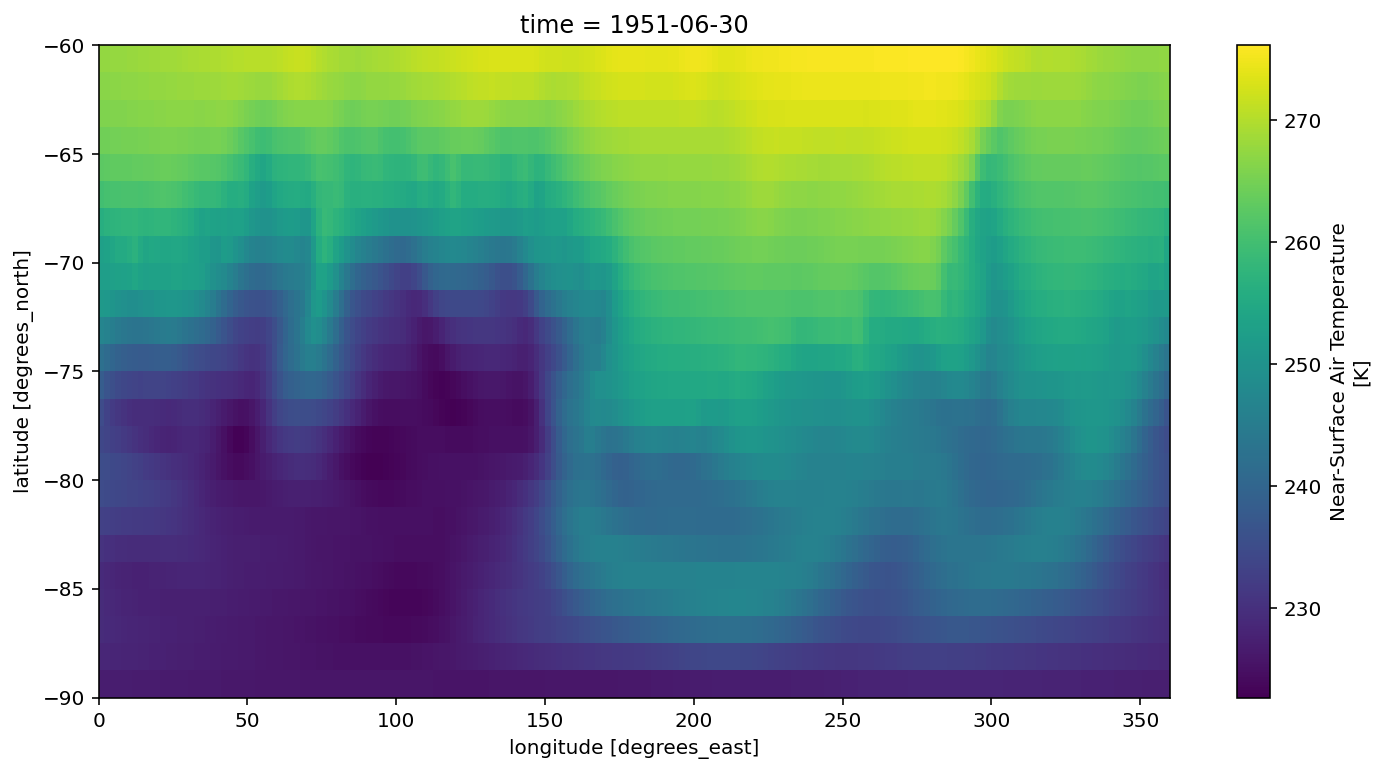

In [32]:
# Prepare GCM
TAS = antarctica.drop_vars([
    'TIME2_bnds',
    'UA',
    'VA',
    'ZG',
    'PLEV12_15_bnds',
    'TA',
    ])
TAS = TAS.rename({'LAT': 'lat', 'LON': 'lon', 'TIME': 'time'})
TAS = TAS.sortby(['lat', 'lon', 'time'])
TAS.TAS.isel(time=1).plot(x='lon')
TAS.load()

In [33]:
# Define the source and target projections
source_crs = pyproj.CRS(3031) # Coordinate system of the file
target_crs = pyproj.CRS(init="epsg:4326") # Global lat-lon coordinate system

TAS_latlon = TAS.rio.write_crs(target_crs)
TAS_latlon.attrs['crs']  = target_crs

print('Shape of original data, time: {}, lat: {}, lon: {}'.format(TAS_latlon.TAS.shape[0],
                                                                  TAS_latlon.TAS.shape[1],
                                                                  TAS_latlon.TAS.shape[2]))

# Create a grid of lat/lon values for the lat/lon grid of GCM over antarctic
lonmesh, latmesh = np.meshgrid(TAS_latlon.lon, TAS_latlon.lat)

# Create a pyproj.Transformer to transform each point 
# in lonmesh and lastmesh into a location in the polar coordinates 
latlon_to_polar = pyproj.Transformer.from_crs(target_crs, source_crs)

# polar coordinates from lat-lon
x_om2, y_om2 = latlon_to_polar.transform(lonmesh, latmesh)

# Use the xarray interp method to find the nearest locations 
# for each transformed point
# To do this need to create xarray.DataArray for the coordinates with matching dimensions.
x_om2 = xr.DataArray(x_om2, dims=('lat','lon'))
y_om2 = xr.DataArray(y_om2, dims=('lat','lon'))

data_om2 = SF_xy.interp({'x':x_om2, 'y':y_om2}, method='nearest').load()

# Assign new coordinates
data_om2 = data_om2.assign_coords({'lon': (('lon'), TAS_latlon.lon.data), 
                                   'lat': (('lat'), TAS_latlon.lat.data)}).drop_vars(['x','y']).reset_coords()
data_om2.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Shape of original data, time: 151, lat: 24, lon: 192


<xarray.Dataset>
Dimensions:      (time: 121, lon: 192, lat: 24)
Coordinates:
  * time         (time) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * lon          (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat          (lat) float64 -89.38 -88.12 -86.88 ... -63.12 -61.88 -60.62
Data variables:
    spatial_ref  int64 0
    SF           (time, lat, lon) float32 85.65 85.65 85.65 ... nan nan nan

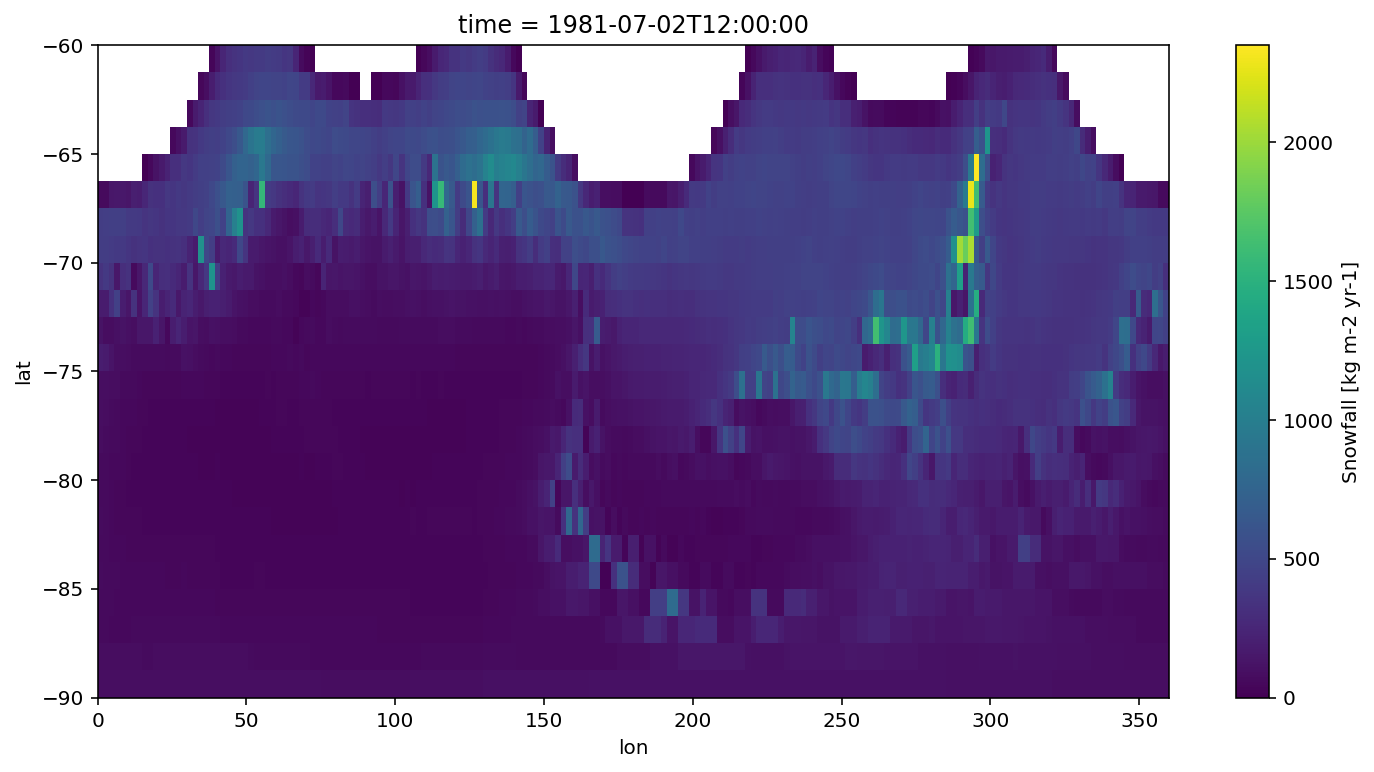

In [34]:
data_om2.SF.isel(time = 1).plot();

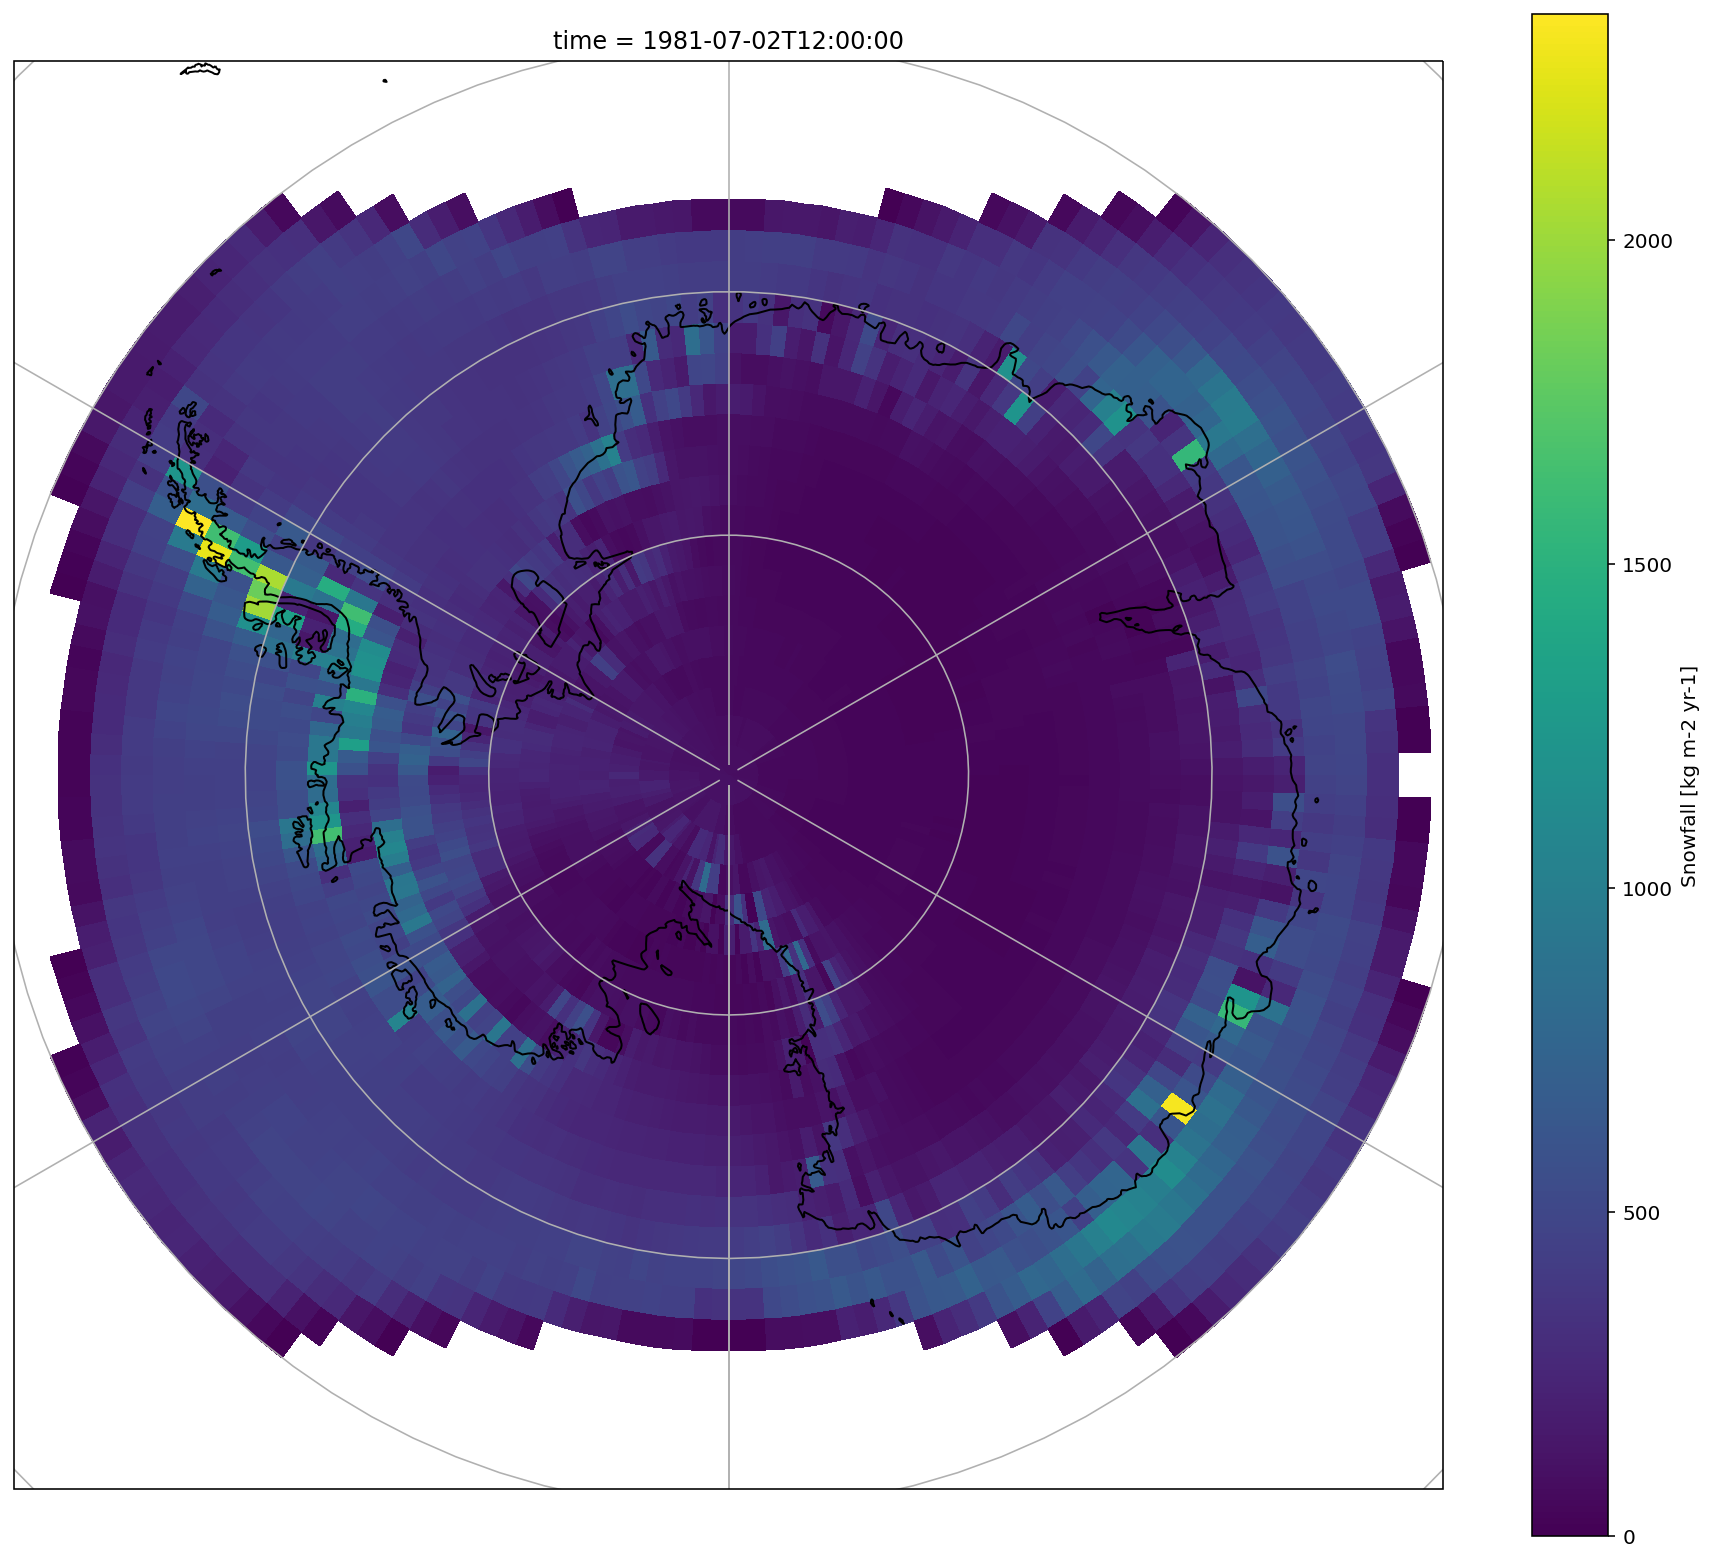

In [36]:
fig = plt.figure(figsize=(16, 14))
projection = ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)

# map
ax.set_extent((-3333000, 3333000, -3333000, 3333000),
              crs=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')

ax.gridlines()
data_om2.SF.isel(time=1).plot(ax=ax, x='lon', y='lat',
                              transform=ccrs.PlateCarree())  # data transform

## Interpolate GCM lat/lon -> x/y:

Change GCM from lat/lon coordinates -> x/y polar stereographic coordinates

In [27]:
# Prepare RCM
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
SF = dsr.SF.rename({'X':'x', 'Y':'y','TIME':'time'})
SF_xy = SF.rio.write_crs("epsg:3031")

# Convert RCM from km to m for plots:
SF_xy['x'] = SF_xy.x*1000
SF_xy['y'] = SF_xy.y*1000
SF_xy.x.attrs['units'] = 'm'
SF_xy.y.attrs['units'] = 'm'

SF_xy.load()

print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(SF_xy.x.max().data, 
                                                                     SF_xy.x.min().data, 
                                                                     SF_xy.y.max().data, 
                                                                     SF_xy.y.min().data))

Max and min values of x: 3115000.25m -> -3010000.25m and y: 2590000.0m -> -2555000.0m


#### Create GCM like x-y grid to interpolate on:
GCM resolution is (lat,lon) = (1.875, 1.25). At the south pole we can calculate that approximately in km like this:

X = (0.25 * [Distance between longitude lines at a given location]), Y = (0.25 * [Distance between latitude lines at a given location])

In our case at lat -60° (antarctica) d(lon) = 55km and d(lat) = 110km so resolution in km (X,Y) = (68, 206)

In [28]:
GCM = antarctica.rename({'LAT':'lat', 'LON':'lon','TIME':'time'})
GCM = GCM.sortby(["lat", "lon","time"])
print_raster(GCM.TAS)

shape: (24, 192)
resolution: (1.875, 1.25)
bounds: (0.0, -60.0, 360.0, -90.0)
sum: 172970704.0
CRS: None



In [29]:
# interpolate RCM grid to 68km, 206km resolution 
print_raster(SF_xy)

shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
sum: 874292928.0
CRS: EPSG:3031



In [30]:
# interpolate xmesh, ymesh 
from scipy import interpolate

xmesh, ymesh = np.meshgrid(SF_xy.x, SF_xy.y)
f = interpolate.interp2d(x, y, a, kind='linear')

### Create right part of plot:
Somehow because of weird differences in pyproj and original grid, have to work in two steps and create the right and left parts of the plot separately and then merge.

In [29]:
%%time
## Prepare GCM
#TAS = antarctica.drop_vars(['TIME2_bnds','UA','VA','ZG','PLEV12_15_bnds'])
GCM = antarctica.rename({'LAT':'lat', 'LON':'lon','TIME':'time'})
GCM = GCM.sortby(["lat", "lon","time"])

print('[GCM original] lon: {}° -> {}° and lat: {}° -> {}°'.format(GCM.lon.min().data, 
                                                                     GCM.lon.max().data, 
                                                                     GCM.lat.min().data, 
                                                                     GCM.lat.max().data))

# ----------- Set information ----------
# Define the source and target projections
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file

# GCM -epsg:4326
GCM_latlon = GCM.rio.write_crs(source_crs)
GCM_latlon.attrs['crs']  = source_crs

# RCM - epsg:3031
SF_xy.attrs['crs']  = target_crs
SF_xy = SF_xy.rio.write_crs(target_crs)
print('--------')
print('Shape of GCM data, time: {}, lat: {}, lon: {}'.format(GCM_latlon.TAS.shape[0],
                                                             GCM_latlon.TAS.shape[1],
                                                             GCM_latlon.TAS.shape[2]))
print('Shape of RCM data, time: {}, x: {}, y: {}'.format(SF_xy.shape[0],
                                                         SF_xy.shape[1],
                                                         SF_xy.shape[2]))

# ----------- Create new coordinates ----------
# Create a grid of x/y values from RCM (onto which we want to project)
xmesh, ymesh = np.meshgrid(SF_xy.x, SF_xy.y)
print('Mesh shapes: {0}, {1}'.format(xmesh.shape, 
                                     ymesh.shape))

# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
polar_to_latlon = pyproj.Transformer.from_crs(target_crs, 
                                              source_crs, 
                                              always_xy = True)

# polar coordinates from lat-lon
lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

print('--------')
print('[Lat-lon mesh] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
print('[After transf] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# ----------- Interpolate ----------
# Use the xarray interp method to find the nearest locations 
# for each transformed point 
print('--------')
print('[TAS before interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(GCM_latlon.lon.min().data, 
                                                                     GCM_latlon.lon.max().data, 
                                                                     GCM_latlon.lat.min().data, 
                                                                     GCM_latlon.lat.max().data))

GCM_latlon_int = GCM_latlon.interp({'lon':lon_om2, 'lat':lat_om2}, method='nearest').load()
print('--------')
print('[TAS after interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(GCM_latlon_int.lon.min().data, 
                                                                     GCM_latlon_int.lon.max().data, 
                                                                     GCM_latlon_int.lat.min().data, 
                                                                     GCM_latlon_int.lat.max().data))
# Replace coordinates by new coordinates
GCM_xy_right = GCM_latlon_int.assign_coords({'x': (('x'), SF_xy.x.data), 
                                   'y': (('y'), SF_xy.y.data)}).drop_vars(['lon','lat']).reset_coords()
GCM_xy_right.load()

[GCM original] lon: 0.9375° -> 359.0625° and lat: -89.375° -> -60.625°
--------
Shape of GCM data, time: 151, lat: 24, lon: 192
Shape of RCM data, time: 121, x: 148, y: 176
Mesh shapes: (148, 176), (148, 176)
--------
[Lat-lon mesh] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
[After transf] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
--------
[TAS before interpolation] lon: 0.94° -> 359.06° and lat: -89.38° -> -60.62°
--------
[TAS after interpolation] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
CPU times: user 481 ms, sys: 225 ms, total: 706 ms
Wall time: 700 ms


<xarray.Dataset>
Dimensions:         (PLEV: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

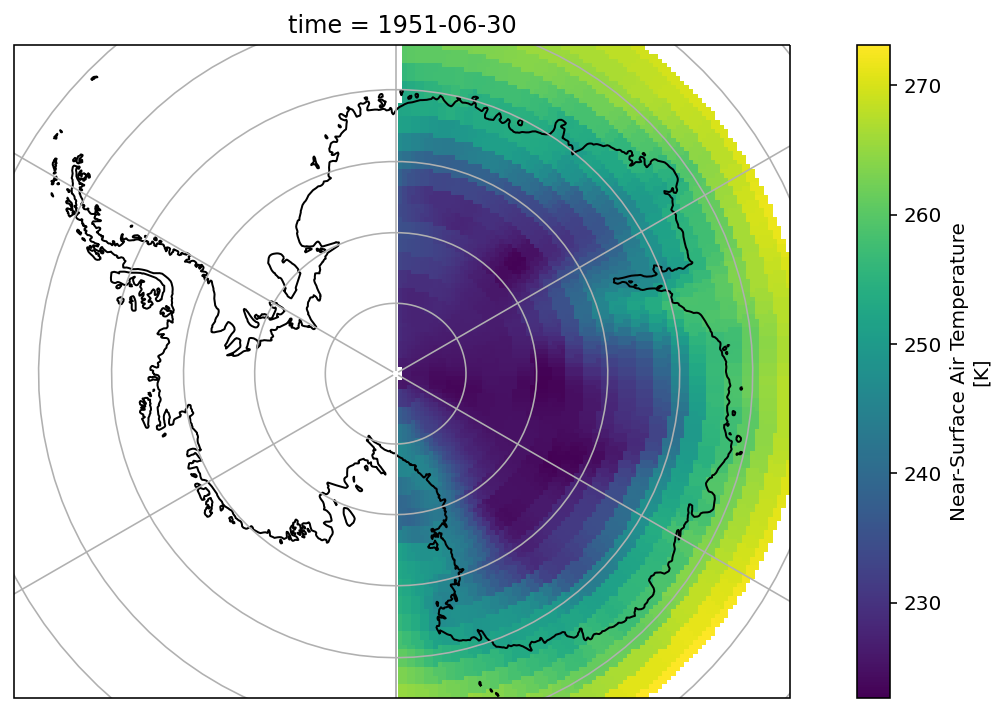

In [30]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy_right.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

### Create left part of plot:

In [33]:
%%time
## Prepare GCM
# For now drop all variables that are not of dimension (time, lat, lon)
GCM = antarctica.rename({'LAT':'lat', 'LON':'lon','TIME':'time'})
GCM = GCM.sortby(["lat", "lon","time"])
#TAS = antarctica.drop_vars(['TIME2_bnds','UA','VA','ZG','PLEV12_15_bnds','TA'])

print('[TAS original] lon: {}° -> {}° and lat: {}° -> {}°'.format(GCM.lon.min().data, 
                                                                     GCM.lon.max().data, 
                                                                     GCM.lat.min().data, 
                                                                     GCM.lat.max().data))
# ----------- Transform GCM ----------
# Change all longitude coordinates to map from -180° -> 180°
GCM['lon'] = GCM.lon-180
print('[After transf] lon: {}° -> {}° and lat: {}° -> {}°'.format(GCM.lon.min().data, 
                                                                     GCM.lon.max().data, 
                                                                     GCM.lat.min().data, 
                                                                     GCM.lat.max().data))
# ----------- Set information ----------
# Define the source and target projections
target_crs = pyproj.CRS(3031) # Global lat-lon coordinate system
source_crs = pyproj.CRS(4326) # Coordinate system of the file

# GCM -epsg:4326
GCM_latlon = GCM.rio.write_crs(source_crs)
GCM_latlon.attrs['crs']  = source_crs

# RCM - epsg:3031
SF_xy.attrs['crs']  = target_crs
SF_xy = SF_xy.rio.write_crs(target_crs)
print('--------')
print('Shape of GCM data, time: {}, lat: {}, lon: {}'.format(GCM_latlon.TAS.shape[0],
                                                             GCM_latlon.TAS.shape[1],
                                                             GCM_latlon.TAS.shape[2]))
print('Shape of RCM data, time: {}, x: {}, y: {}'.format(SF_xy.shape[0],
                                                         SF_xy.shape[1],
                                                         SF_xy.shape[2]))

# ----------- Create new coordinates ----------
# Create a grid of x/y values from RCM (onto which we want to project)
xmesh, ymesh = np.meshgrid(SF_xy.x, SF_xy.y)
print('Mesh shapes: {0}, {1}'.format(xmesh.shape, 
                                     ymesh.shape))

# Create a pyproj.Transformer to transform each point 
# in xmesh and ymesh into a location in the polar coordinates 
polar_to_latlon = pyproj.Transformer.from_crs(target_crs, 
                                              source_crs, 
                                              always_xy = True)

# polar coordinates from lat-lon
lon_om2, lat_om2 = polar_to_latlon.transform(xmesh, ymesh)

# Create xarray.DataArray for the coordinates with matching dimensions.
lon_om2 = xr.DataArray(lon_om2, dims=('y','x'))
lat_om2 = xr.DataArray(lat_om2, dims=('y','x'))

print('--------')
print('[Lat-lon mesh] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# Transform lat lon mesh to get left part, add 180° to longitude
lon_om2 = lon_om2+180

print('[After transf] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(lon_om2.min().data, 
                                                                     lon_om2.max().data, 
                                                                     lat_om2.min().data, 
                                                                     lat_om2.max().data))
# ----------- Interpolate ----------
# Use the xarray interp method to find the nearest locations 
# for each transformed point 
print('--------')
print('[TAS before interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(GCM_latlon.lon.min().data, 
                                                                     GCM_latlon.lon.max().data, 
                                                                     GCM_latlon.lat.min().data, 
                                                                     GCM_latlon.lat.max().data))

GCM_latlon_int = GCM_latlon.interp({'lon':lon_om2, 'lat':lat_om2}, method='nearest').load()
print('--------')
print('[TAS after interpolation] lon: {0:.2f}° -> {1:.2f}° and lat: {2:.2f}° -> {3:.2f}°'.format(GCM_latlon_int.lon.min().data, 
                                                                     GCM_latlon_int.lon.max().data, 
                                                                     GCM_latlon_int.lat.min().data, 
                                                                     GCM_latlon_int.lat.max().data))
# Replace coordinates by new coordinates
GCM_xy_left = GCM_latlon_int.assign_coords({'x': (('x'), SF_xy.x.data), 
                                   'y': (('y'), SF_xy.y.data)}).drop_vars(['lon','lat']).reset_coords()
GCM_xy_left.load()

[TAS original] lon: 0.9375° -> 359.0625° and lat: -89.375° -> -60.625°
[After transf] lon: -179.0625° -> 179.0625° and lat: -89.375° -> -60.625°
--------
Shape of GCM data, time: 151, lat: 24, lon: 192
Shape of RCM data, time: 121, x: 148, y: 176
Mesh shapes: (148, 176), (148, 176)
--------
[Lat-lon mesh] lon: -180.00° -> 179.22° and lat: -90.00° -> -53.91°
[After transf] lon: 0.00° -> 359.22° and lat: -90.00° -> -53.91°
--------
[TAS before interpolation] lon: -179.06° -> 179.06° and lat: -89.38° -> -60.62°
--------
[TAS after interpolation] lon: 0.00° -> 359.22° and lat: -90.00° -> -53.91°
CPU times: user 524 ms, sys: 180 ms, total: 705 ms
Wall time: 701 ms


<xarray.Dataset>
Dimensions:         (PLEV: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

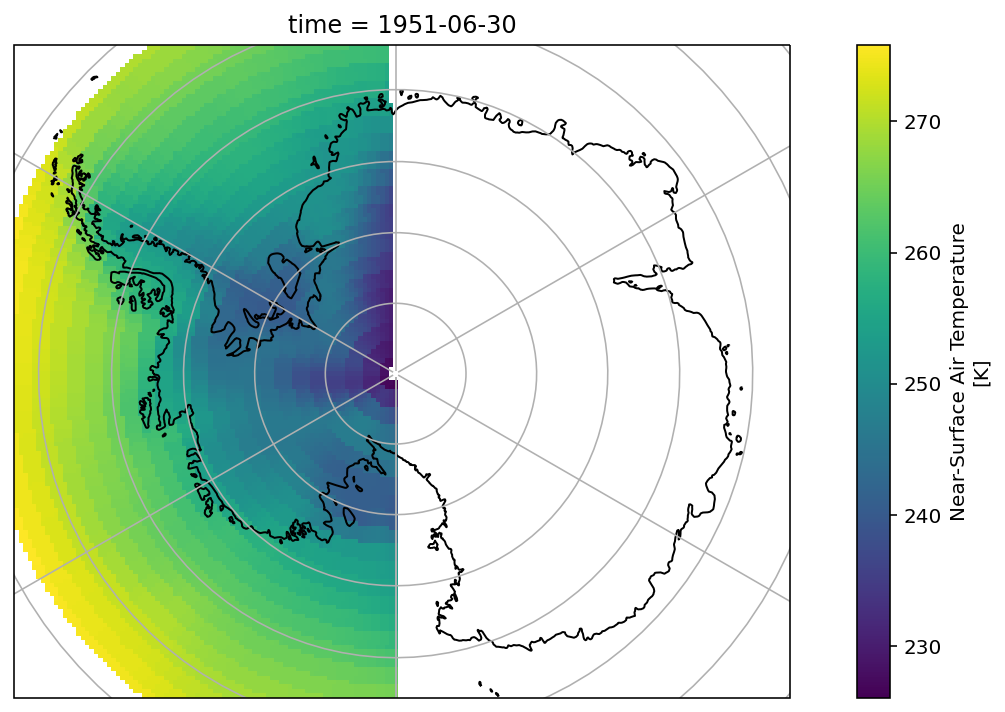

In [34]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy_left.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

### Assemble two parts:

In [43]:
GCM_xy = GCM_xy_right.merge(GCM_xy_left)
GCM_xy.load()

<xarray.Dataset>
Dimensions:         (PLEV: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       epsg:4326

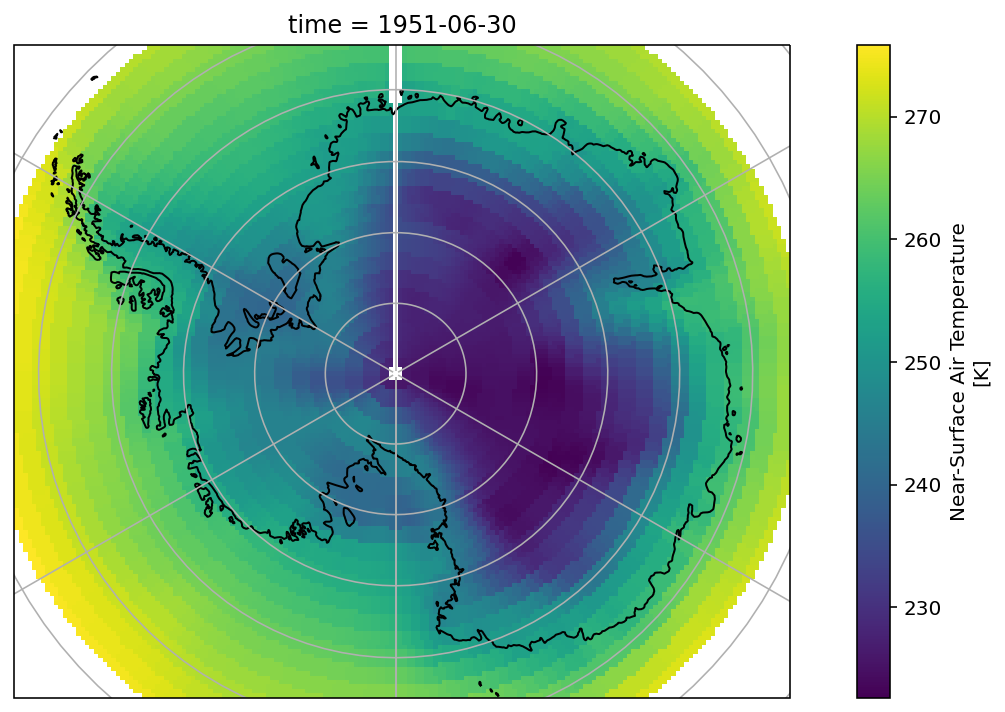

In [44]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data

ax.coastlines()
ax.gridlines()

In [45]:
# save new projection to google cloud
# Access file
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3-stereographic.zarr'
GCM_xy.attrs['crs'] = 4326
GCM_xy.to_zarr('gs://'+globalName)

ContainsGroupError: path '' contains a group

In [42]:
GCM_xy

<xarray.Dataset>
Dimensions:         (PLEV: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * PLEV            (PLEV) float64 5e+04 6e+04 7e+04 8.5e+04
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (PLEV, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, PLEV, y, x) float32 nan nan nan nan ... nan nan nan
    spatial_ref     int64 0
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1
    crs:                       4326